In [26]:
# Compute and plot the number of cc detections per hour and compare them with the number of STA-LTA detections

In [27]:
## Import modules
from os.path import join
from utils_cc import read_template_and_match, get_timewin_from_template_name, get_subarray_from_template_name
from obspy import UTCDateTime
from pandas import to_datetime, read_csv, Grouper, DataFrame
from matplotlib.pyplot import subplots, savefig, close
from matplotlib.dates import DayLocator

In [28]:
## Inputs
tempname = "TwinA12-17-23-38"
suffix = "bandpass10-450hz_dur0.04s_mincc0.7_mindet4"
rootdir = "/Volumes/OmanData/geophones_no_prefilt/data"

countmax = 3800


In [29]:
## Read template and match
timewin = get_timewin_from_template_name(tempname)
inpath = join(rootdir, timewin, f"ccmatches_{tempname}_{suffix}.dat")
template_and_match = read_template_and_match(inpath)
template = template_and_match.template
matches = template_and_match.matches

In [30]:
## Read the STA-LTA detections
inpath = join(rootdir, "sta_lta_detections.csv")
staltadf = read_csv(inpath, delimiter=" ")
staltadf["hour"] = to_datetime(staltadf["hour"], format="%Y-%m-%d-%H-%M-%S")
staltadf = staltadf.set_index("hour")

In [31]:
## Get the number of matched events per hour
timedf = DataFrame(matches.get_match_times(), columns=["time"])
timedf.set_index("time", inplace=True)

ccdf = timedf.groupby(Grouper(freq="1H")).size()

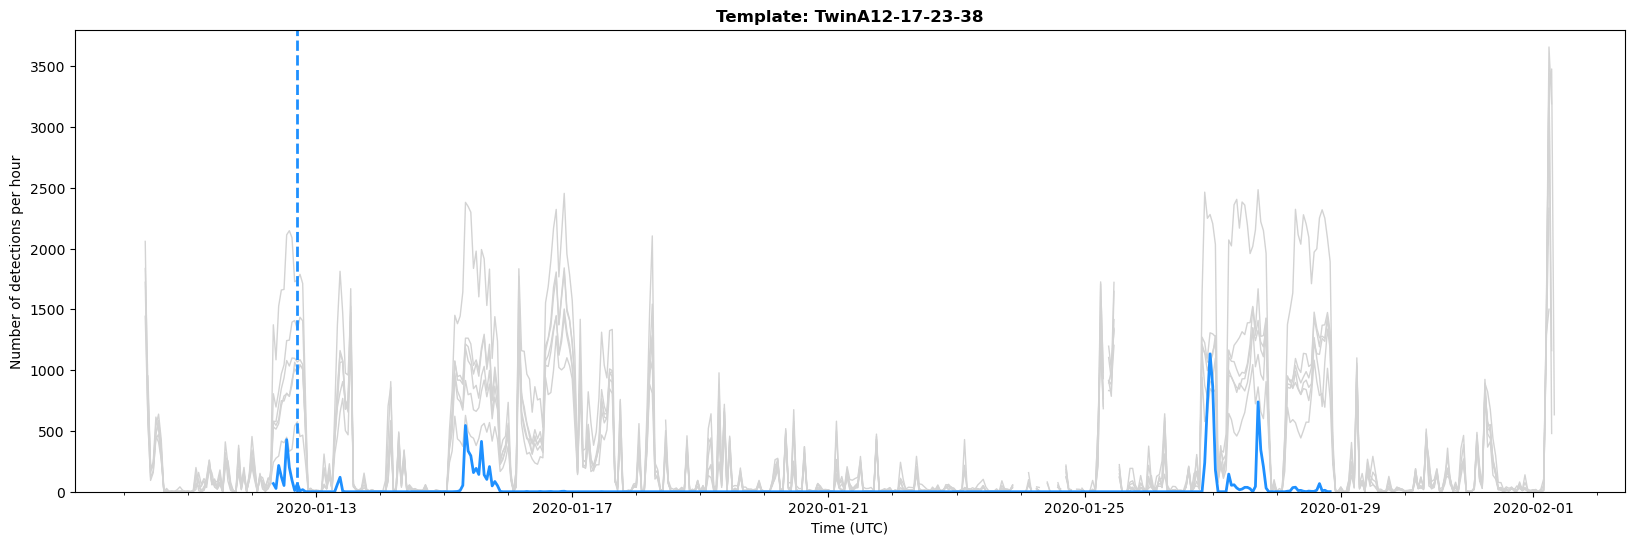

In [32]:
## Plot the number of detections per hour

### Get the subarray
subarray = get_subarray_from_template_name(tempname)

### Get the stations to plot
if subarray == "A":
    stations_plot = ["A01", "A02", "A03", "A04", "A05", "A06"]
    linecolor =  "dodgerblue"
elif subarray == "B":
    stations_plot = ["B01", "B02", "B03", "B04", "B06"]
    linecolor = "darkorange"
else:
    raise ValueError("Unknown subarray")

fig, ax = subplots(1, 1, figsize=(20, 6))

if stations_plot[0][0] == "A":
    linecolor =  "dodgerblue"
else:
    linecolor = "darkorange"

### Plot the STA-LTA detections
hours_stalta = staltadf.index
for station in stations_plot:
    counts = staltadf[station]

    ax.plot(hours_stalta, counts, label=station, color="lightgray", linewidth=1)

### Plot the cc detections
hours_cc = ccdf.index
counts = ccdf.values
ax.plot(hours_cc, counts, label="cc", color=linecolor, linewidth=2)

time_template = template.first_start_time
hour_template = time_template.replace(minute=0, second=0, microsecond=0)    

ax.axvline(x=hour_template, color=linecolor, linestyle="--", linewidth=2)

ax.set_ylim(0, countmax)

ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Number of detections per hour")

ax.set_title(f"Template: {tempname}", fontsize=12, fontweight="bold")
ax.xaxis.set_minor_locator(DayLocator())

### Save figure
outpath = join(rootdir, timewin, f"cc_vs_stalta_{tempname}_{suffix}.png")

fig.savefig(outpath, dpi=300, bbox_inches="tight")
